In [1]:
import numpy as np
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, Lambda
from keras import backend as K
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow import keras


2024-01-22 16:19:16.222113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 16:19:16.273948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 16:19:16.273982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 16:19:16.274022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 16:19:16.285324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 16:19:16.285858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
embeddings = torch.load("training_data.pt",  map_location=torch.device("cpu"))

In [3]:
X_pairs = []
Y_labels = []
for embedding in tqdm(embeddings):
    X_pairs.append([
        embedding["embed1"].numpy(),
        embedding["embed2"].numpy()
    ])
    Y_labels.append(1 if embedding["equal"] else 0)

100%|██████████| 157535/157535 [00:01<00:00, 94776.26it/s] 


In [4]:
train_test_ratio = 0.8
n_train_samples = int(len(embeddings)*train_test_ratio)

X_train = np.array(X_pairs[:n_train_samples])
X_test = np.array(X_pairs[n_train_samples:])

Y_train = np.array(Y_labels[:n_train_samples]).astype(np.float32)
Y_test = np.array(Y_labels[n_train_samples:]).astype(np.float32)

In [5]:
def manhattan_distance(vects):
    """Find the Manhattan distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing manhattan distance
        (as floating point value) between vectors.
    """

    x, y = vects
    return K.abs(x - y)


input = keras.layers.Input((768,))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(768, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((768,))
input_2 = keras.layers.Input((768,))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(manhattan_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


2024-01-22 16:19:46.929643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - (y_pred), 0))
    return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)    

In [7]:
siamese.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  596736    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['model[0][0]',         

In [8]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(monitor='loss', patience=3, min_delta=0.01, restore_best_weights=True)

history = siamese.fit(
    [X_train[:,0], X_train[:,1]],
    Y_train,
    #validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks = [early_stopping]
)

Epoch 1/50
3939/3939 [==============================] - 22s 5ms/step - loss: 0.0537 - accuracy: 0.9299
Epoch 2/50
3939/3939 [==============================] - 21s 5ms/step - loss: 0.0211 - accuracy: 0.9768
Epoch 3/50
3939/3939 [==============================] - 21s 5ms/step - loss: 0.0134 - accuracy: 0.9856
Epoch 4/50
3939/3939 [==============================] - 21s 5ms/step - loss: 0.0101 - accuracy: 0.9892
Epoch 5/50
3939/3939 [==============================] - 21s 5ms/step - loss: 0.0082 - accuracy: 0.9911
Epoch 6/50
3939/3939 [==============================] - 21s 5ms/step - loss: 0.0068 - accuracy: 0.9924
Epoch 7/50
3939/3939 [==============================] - 21s 5ms/step - loss: 0.0058 - accuracy: 0.9938


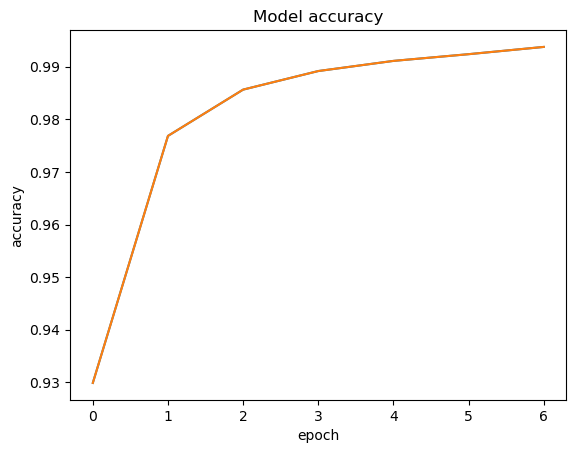

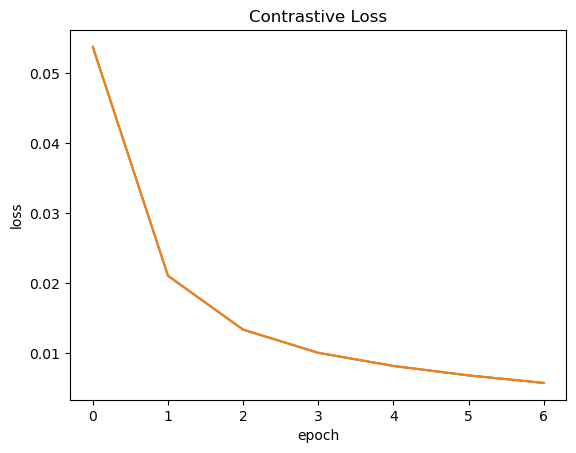

In [12]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history[metric])
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [13]:
evaluation = siamese.evaluate([X_test[:,0], X_test[:,1]], Y_test)

985/985 [==============================] - 2s 2ms/step - loss: 0.0187 - accuracy: 0.9767


In [ ]:
siamese.save_weights("siamese_network_keras_weights.h5")

In [27]:
siamese.load_weights("siamese_network_keras_weights.h5")

siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  596736    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 768)                  0         ['model[0][0]',         

In [17]:
n=10
to_pred = X_test[:n]
print(siamese.predict([to_pred[:,0], to_pred[:,1]]))
print(Y_test[:n])

1/1 [==============================] - 0s 18ms/step
[[9.9779153e-01]
 [8.4838463e-04]
 [9.8065531e-01]
 [3.7515903e-05]
 [3.0332076e-05]
 [6.1447144e-01]
 [2.2278418e-04]
 [5.1730819e-04]
 [1.0908953e-02]
 [9.9857736e-01]]
[1. 0. 1. 0. 0. 1. 0. 0. 0. 1.]


In [18]:
XX = siamese.input 
YY = siamese.layers[2].output
new_model = Model(XX, YY)

#Xaug = X_train[:9]
#Xresult = new_model.predict(Xaug)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "batch_normalization". The following previous layers were accessed without issue: []